# Проект: Обучение для текстов

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# установим необходимые библиотеки
import pandas as pd
import numpy as np

import pymorphy2
from pymystem3 import Mystem
import re

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# загрузим датасет
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
# посмотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
# удалим ненужный столбец
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# посмотрим есть ли дубликаты
df.duplicated().sum()

0

<AxesSubplot:>

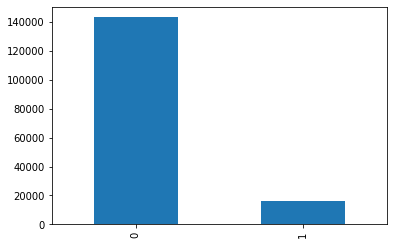

In [6]:
# посмотрим на соотношение классов в столбце 'toxic'
df['toxic'].value_counts().plot.bar()

In [7]:
# найдем отношение кслассов в столбце 'toxic'
df['toxic'].value_counts()[1] / df['toxic'].value_counts()[0]

0.11310497114027364

In [8]:
#ввожу функцию очищения текстов постов:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [9]:
df['text'] = df['text'].apply(clear_text)
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [10]:
#ввожу функцию РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

#ввожу функцию леммализации тектов постов:
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)


'lemmatizer = WordNetLemmatizer()\n\ndef lemmatize(text):\n    text = text.lower()\n    lemm_text = "".join(lemmatizer.lemmatize(text))\n    cor_text = re.sub(r\'[^a-zA-Z]\', \' \', lemm_text) \n    return " ".join(cor_text.split())'

In [11]:
# применим нашу функцию для создания нового столбца 'lemm_text'
df['lemm_text'] = df['text'].apply(lemm_text)
df = df.drop(['text'], axis=1)
df.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


**Вывод:** Нам дан датасет без ошибок, без дубликатов и с правильными типами данных. Мы провели удаление ненужного столбца, провели лемматизацию текстов. И в результате у нас получился готовый к анализу датасет. Но в нашем датасете есть дисбаланс классов, который еще нужно будет подправить при проведении обучения.

## Обучение

In [12]:
# выделим целевой признак и разделим данные на тренировочную, валидационную и тестовую выборки
feat = df.drop('toxic', axis=1)
targ = df['toxic']
feat_train, feat_valid, targ_train, targ_valid = train_test_split(feat, targ, test_size=0.4, random_state=25)
feat_valid, feat_test, targ_valid, targ_test = train_test_split(feat_valid, targ_valid, test_size=0.5, random_state=25)

In [13]:
print(feat_train.shape)
print(feat_valid.shape)
print(feat_test.shape)

(95575, 1)
(31858, 1)
(31859, 1)


In [15]:
# рассчитаем величину TF-IDF и применим её к выборкам
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

feat_train = count_tf_idf.fit_transform(feat_train['lemm_text'].values)
feat_valid = count_tf_idf.transform(feat_valid['lemm_text'].values)
feat_test = count_tf_idf.transform(feat_test['lemm_text'].values)
print(feat_train.shape)
print(feat_valid.shape)
print(feat_test.shape)

(95575, 111347)
(31858, 111347)
(31859, 111347)


### Модель LogisticRegression 

In [21]:
# модель LogisticRegression: обучим модель, найдём лучшие параметры, найдем F1.

parameters_log_reg = {'class_weight': ['balanced', None], 'random_state': [25],
                      'C':[0.1, 1, 5], 'solver':['newton-cg', 'lbfgs', 'liblinear']}                   
model_log_reg = LogisticRegression()
grid_log_reg = GridSearchCV(estimator=model_log_reg, scoring='f1', param_grid=parameters_log_reg, cv=5)
#grid_log_reg.fit(feat_downsampled_train, targ_downsampled_train)
grid_log_reg.fit(feat_train, targ_train)
predicted_log_reg = grid_log_reg.predict(feat_valid)
log_reg_best_params = grid_log_reg.best_params_
print(log_reg_best_params)
print('F1 равно:', f1_score(targ_valid, predicted_log_reg))

{'C': 5, 'class_weight': 'balanced', 'random_state': 25, 'solver': 'liblinear'}
F1 равно: 0.7635796340944547


### Модель RandomForestClassifier

In [59]:
# модель RandomForestClassifier: обучим модель, найдём лучшие параметры, найдем F1.

parameters_RFC = {'n_estimators': [50, 100], 'max_depth': [30], 'random_state': [25], 
                  'n_jobs': [-1, None, 1], 'criterion': ['gini', 'entropy', 'log_loss'], 
                  'class_weight': ['balanced']}
model_RFC = RandomForestClassifier()
grid_RFC = GridSearchCV(estimator=model_RFC, param_grid=parameters_RFC, scoring='f1', cv=5)
#grid_RFC.fit(feat_downsampled_train, targ_downsampled_train)
grid_RFC.fit(feat_train, targ_train)
predicted_rfc = grid_RFC.predict(feat_valid)
RFC_best_params = grid_RFC.best_params_
print(RFC_best_params)
print('F1 равно:', f1_score(targ_valid, predicted_rfc))

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 25}
F1 равно: 0.44204487936561504


### Модель DecisionTreeClassifier

In [ ]:
# модель DecisionTreeClassifier: обучим модель, найдём лучшие параметры, найдем F1.

parameters_DTC = {'splitter': ['best', 'random'], 'max_depth': [30, 50], 'random_state': [25], 
                  'criterion': ['gini', 'entropy', 'log_loss'], 'class_weight': ['balanced', None]}
model_DTC = DecisionTreeClassifier()
grid_DTC = GridSearchCV(estimator=model_DTC, param_grid=parameters_DTC, scoring='f1', cv=5)
#grid_DTC.fit(feat_downsampled_train, targ_downsampled_train)
grid_DTC.fit(feat_train, targ_train)
predicted_dtc = grid_DTC.predict(feat_valid)
DTC_best_params = grid_DTC.best_params_
print(DTC_best_params)
print('F1 равно:', f1_score(targ_valid, predicted_dtc))

**Вывод:** После ликвидации сильного дисбаланса в обучающей выборке и проведения машинного обучения на трех моделях, мы можем заключить, что лучшие результаты демонстрирует модель логистической регрессии. Лучшие параметры модели: {'C': 5, 'class_weight': 'balanced', 'random_state': 25, 'solver': 'lbfgs'}. При данных параметрах оценка F1 достигает своего максимального значения и равна 0.76 , что удовлетворяет требованию задачи по минимальной величине оценки равной 0,75.

## Выводы

In [24]:
# найдем значение F1 нашей лучшей модели на тестовой выборке

model_log_reg.set_params(**log_reg_best_params)
#model_log_reg.fit(feat_downsampled_train, targ_downsampled_train)
model_log_reg.fit(feat_train, targ_train)
lg_predict = model_log_reg.predict(feat_test)
print('F1 на тестовых данных равно:', f1_score(targ_test, lg_predict))

F1 на тестовых данных равно: 0.742501414827391


**Вывод:** Наша лучшая модель на тестовых данных показала результат равный 0,76 , что довольно близко к оценке полученной во время обучения, т.о. мы можем сказать, что модель не переобучилась и интернет-магазин «Викишоп» может использовать нашу модель логистической регрессии с параметрами `{'C': 5, 'class_weight': 'balanced', 'random_state': 25, 'solver': 'lbfgs'}`для того чтобы классифицировать комментарии на позитивные и негативные.